Bootstrapping and bagging
=======================

Bootstrapping and bagging can be very useful when using ensemble models such as the Committee. In essence, bootstrapping is random sampling with replacement from the available training data. Bagging (= bootstrap aggregation) is performing it many times and training an estimator for each bootstrapped dataset. It is available in modAL for both the base ActiveLearner model and the Committee model as well. In this short tutorial, we are going to see how to perform bootstrapping and bagging in your active learning workflow.

The executable script for this example can be [found here](https://github.com/cosmic-cortex/modAL/blob/master/examples/bagging.py)!

To enforce a reproducible result across runs, we set a random seed.

In [1]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

The dataset
-----------------
In this short example, we will try to learn the shape of three black disks on a white background.

In [2]:
import numpy as np
from itertools import product

# creating the dataset
im_width = 500
im_height = 500
data = np.zeros((im_height, im_width))
# each disk is coded as a triple (x, y, r), where x and y are the centers and r is the radius
disks = [(150, 150, 80), (200, 380, 50), (360, 200, 100)]
for i, j in product(range(im_width), range(im_height)):
    for x, y, r in disks:
        if (x-i)**2 + (y-j)**2 < r**2:
            data[i, j] = 1

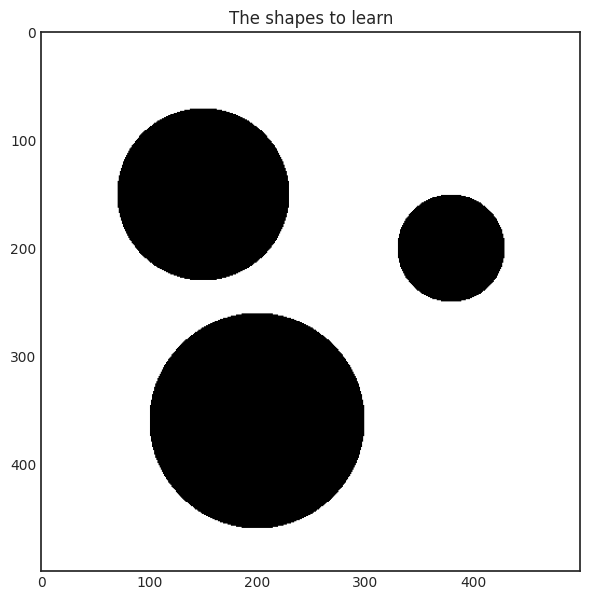

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# visualizing the dataset
with plt.style.context('seaborn-v0_8-white'):
    plt.figure(figsize=(7, 7))
    plt.imshow(data)
    plt.title('The shapes to learn')
    plt.show()

Initializing the learners with bootstrapping
-------------------------------------------------------------

First we shall train three ActiveLearners on a bootstrapped dataset. Then we are going to bundle them together in a Committee and see how bagging is done with modAL.

In [4]:
# create the pool from the image
X_pool = np.transpose(
    [np.tile(np.asarray(range(data.shape[0])), data.shape[1]),
     np.repeat(np.asarray(range(data.shape[1])), data.shape[0])]
)
# map the intensity values against the grid
y_pool = np.asarray([data[P[0], P[1]] for P in X_pool])

# initial training data
initial_idx = np.random.choice(range(len(X_pool)), size=500)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner, Committee

# initializing the learners
n_learners = 3
learner_list = []
for _ in range(n_learners):
    learner = ActiveLearner(
        estimator=KNeighborsClassifier(n_neighbors=10),
        X_training=X_pool[initial_idx], y_training=y_pool[initial_idx],
        bootstrap_init=True
    )
    learner_list.append(learner)

As you can see, the main difference in this from the regular use of ActiveLearner is passing ``bootstrap_init=True`` upon initialization. This makes it to train the model on a bootstrapped dataset, although it stores the *complete* training dataset among its known examples. In this exact case, here is how the classifiers perform:

We can put our learners together in a Committee and see how they perform.

In [6]:
# assembling the Committee
committee = Committee(learner_list)

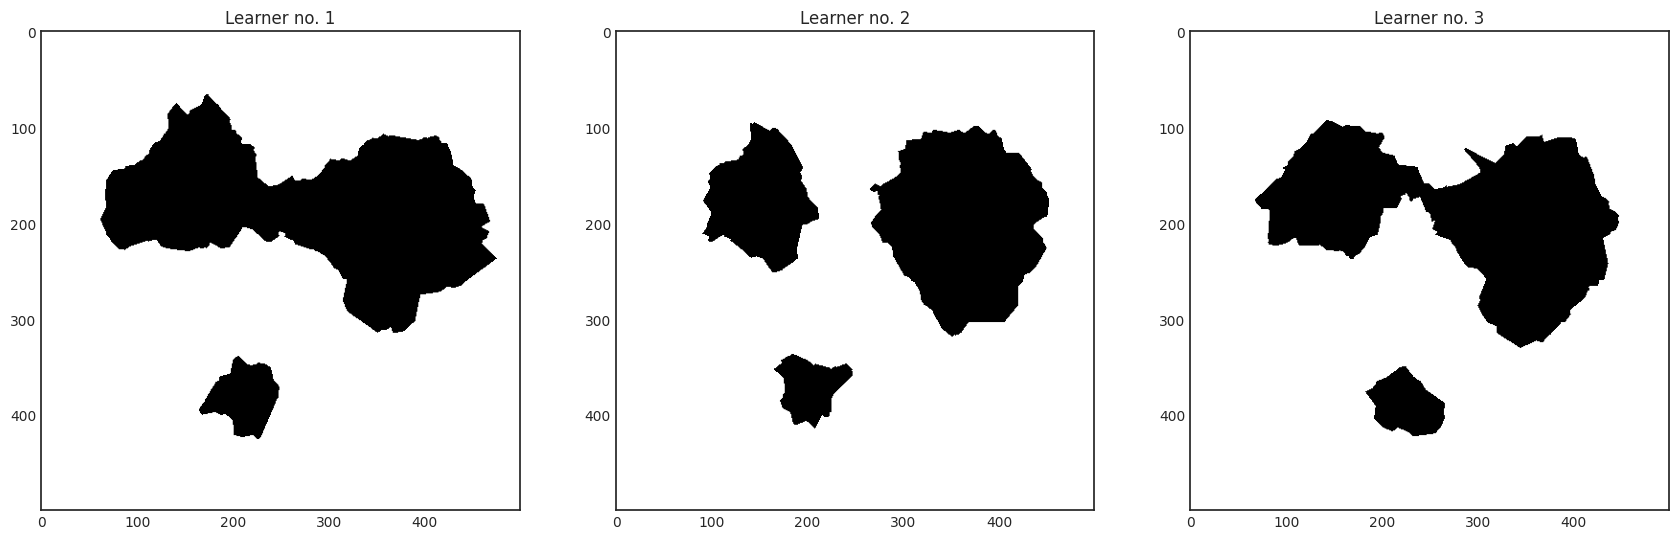

In [7]:
# visualizing every learner in the Committee
with plt.style.context('seaborn-v0_8-white'):
    plt.figure(figsize=(7*n_learners, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_learners, learner_idx+1)
        plt.imshow(learner.predict(X_pool).reshape(im_height, im_width))
        plt.title('Learner no. %d' % (learner_idx + 1))
    plt.show()

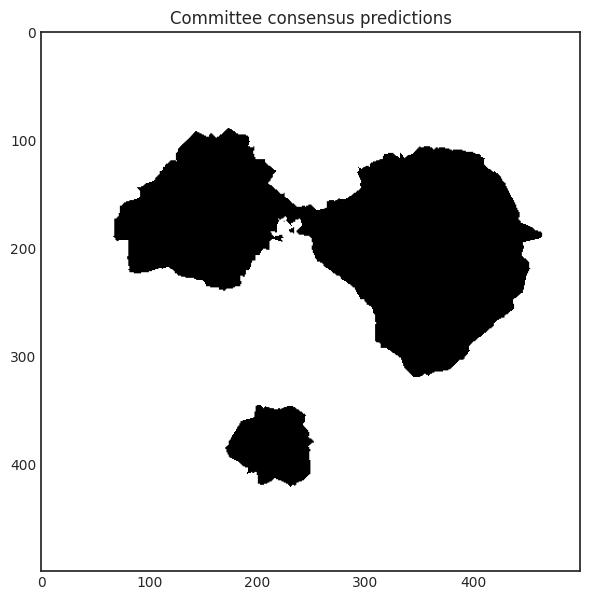

In [8]:
# visualizing the Committee's predictions
with plt.style.context('seaborn-v0_8-white'):
    plt.figure(figsize=(7, 7))
    plt.imshow(committee.predict(X_pool).reshape(im_height, im_width))
    plt.title('Committee consensus predictions')
    plt.show()

Bagging
------------

If you would like to take each learner in the Committee and retrain them using bagging, you can use the ``.rebag()`` method:

In [9]:
committee.rebag()

In this case, the classifiers perform in the following way after
rebagging.

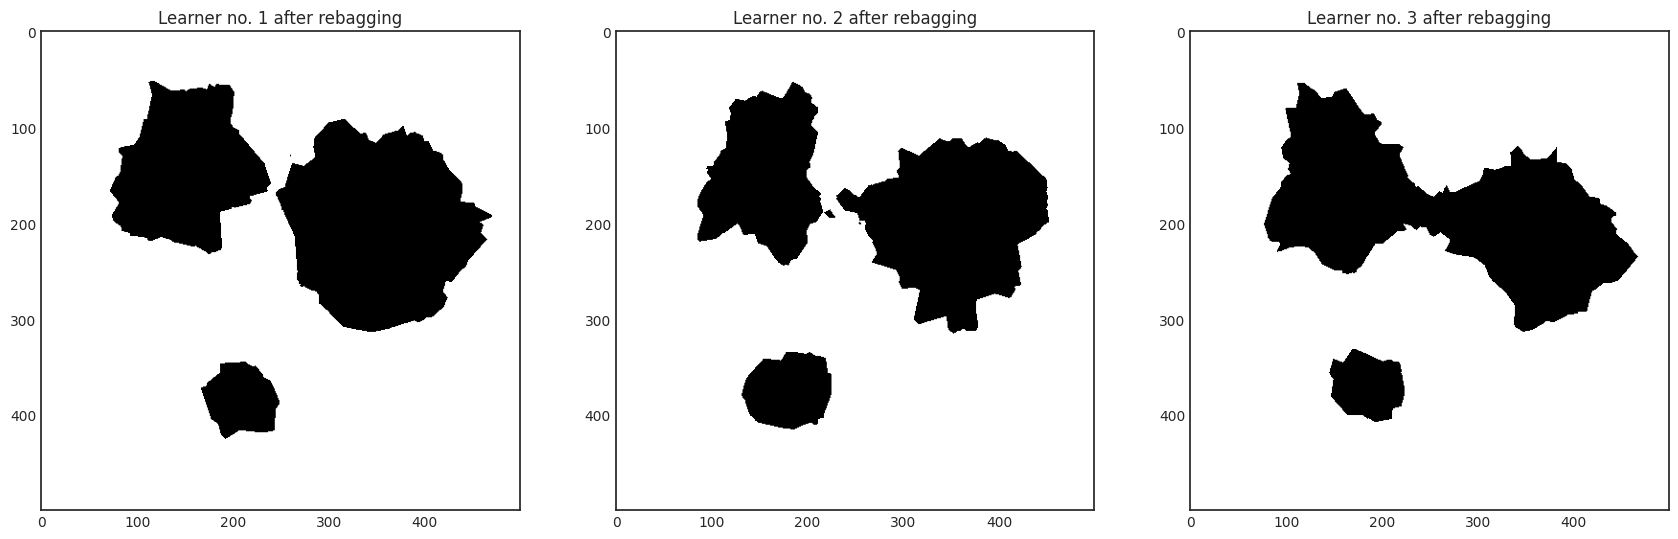

In [10]:
# visualizing the learners in the retrained Committee
with plt.style.context('seaborn-v0_8-white'):
    plt.figure(figsize=(7*n_learners, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_learners, learner_idx+1)
        plt.imshow(learner.predict(X_pool).reshape(im_height, im_width))
        plt.title('Learner no. %d after rebagging' % (learner_idx + 1))
    plt.show()
